# Sign Language Detection Project
## ADA 447 Midterm Project
### Ali Barkın Öztürk

In this project I tried to train a American Sign Language letter detection model.

In [1]:
from fastai.vision.all import *
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image

## A.1. Download the data



I downloaded this dataset from kaggle beacuse I work on locally. This dataset comes with train and test data separated, but the test data contains only one test image from each class, which is not correct or enough. For this reason, I only used train data.

In [3]:
path = Path("./data") 

### A.1.1. Inspect the data layout

Here the data's structure and sample number of each label

In [4]:
class_counts = {}
print("class names \t sample number of class")
for folder in path.ls():
    class_counts[folder.name] = len(list(folder.ls()))
    print(folder.name,"\t\t", class_counts[folder.name])

class names 	 sample number of class
A 		 3000
B 		 3000
C 		 3000
D 		 3000
E 		 3000
F 		 3000
G 		 3000
H 		 3000
I 		 3000
J 		 3000
K 		 3000
L 		 3000
M 		 3000
O 		 3000
P 		 3000
Q 		 3000
R 		 3000
S 		 3000
T 		 3000
U 		 3000
V 		 3000
W 		 3000
X 		 3000
Y 		 3000
Z 		 3000
del 		 3000
nothing 		 3000
space 		 3000
N 		 3000


In here I controlled dataset's image dimensions

In [5]:
size_counter = Counter()

for folder in path.ls():
    for img_path in folder.ls():
        with Image.open(img_path) as img:
            size = img.size
            size_counter[size] += 1

print("Most common image sizes:")
for size, count in size_counter.most_common(10):
    print(f"Size: {size}, Count: {count}")

Most common image sizes:
Size: (200, 200), Count: 87000


### A.1.2. Decide how to create the datablock

This project is a "Multiclass Classification Problem". <br>
Class of the this project is letters of American Alphabet, delete, nothing and space. <br>
As I use images for detect letters, use ImageBlock for input and due to this project is classification problem use CategoryBlock for output.

## A.2. Create the DataBlock and dataloaders

### A.2.1 Define the blocks
### A.2.2 Define the means of getting data into DataBlock
### A.2.3 Define how to get the attributes
Because of data images are in folders according to their classes ı got target datas with parent_label function. <br>
parent_label get the name of the images's parent folder.
As data item is the image ı use get_image_files function.

### A.2.4  Define data transformations

I did not use rotation because using rotation would make it impossible for some letters to change their meanings as a result of not holding the same hand gesture at different angles, which would cause problems during training.</br>
Instead, I aimed to train the letters to be detected in closer situations using zooming and random resizing.

In [6]:
aug_transforms_custom = aug_transforms(
        size=200,
        min_scale=0.6,
        max_zoom=1.8,
        max_lighting=0.7,
        p_affine=0.9,
        p_lighting=0.9
)

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(600),
    batch_tfms=aug_transforms_custom
)

## A.3. Inspect the DataBlock via dataloader

In this section, I created a datablock by setting the batch number to 64, which I thought was appropriate for my data size and graphics card.

In [8]:
dls = dblock.dataloaders(path, bs=64)

### A.3.1 Show  batch: dataloader.show_batch()

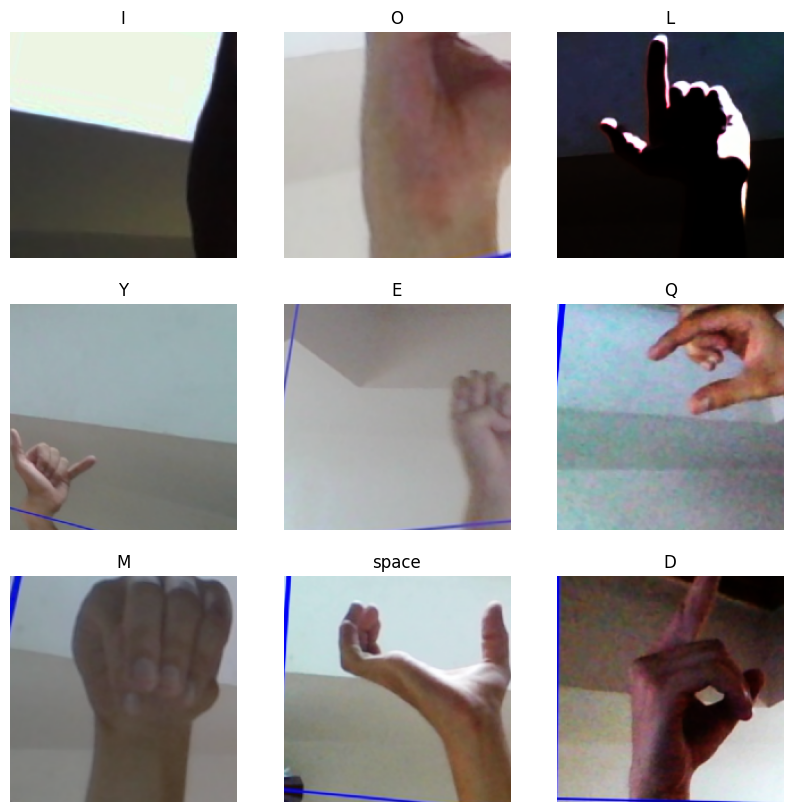

In [9]:
dls.show_batch(max_n=9, figsize=(10, 10))

### A.3.2 Check the labels

Here I took a sample from each class to check whether my data labels were imported correctly.

In [10]:
print(f"Label vocabulary: {dls.vocab}")
print(f"Number of classes: {len(dls.vocab)}")

Label vocabulary: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of classes: 29


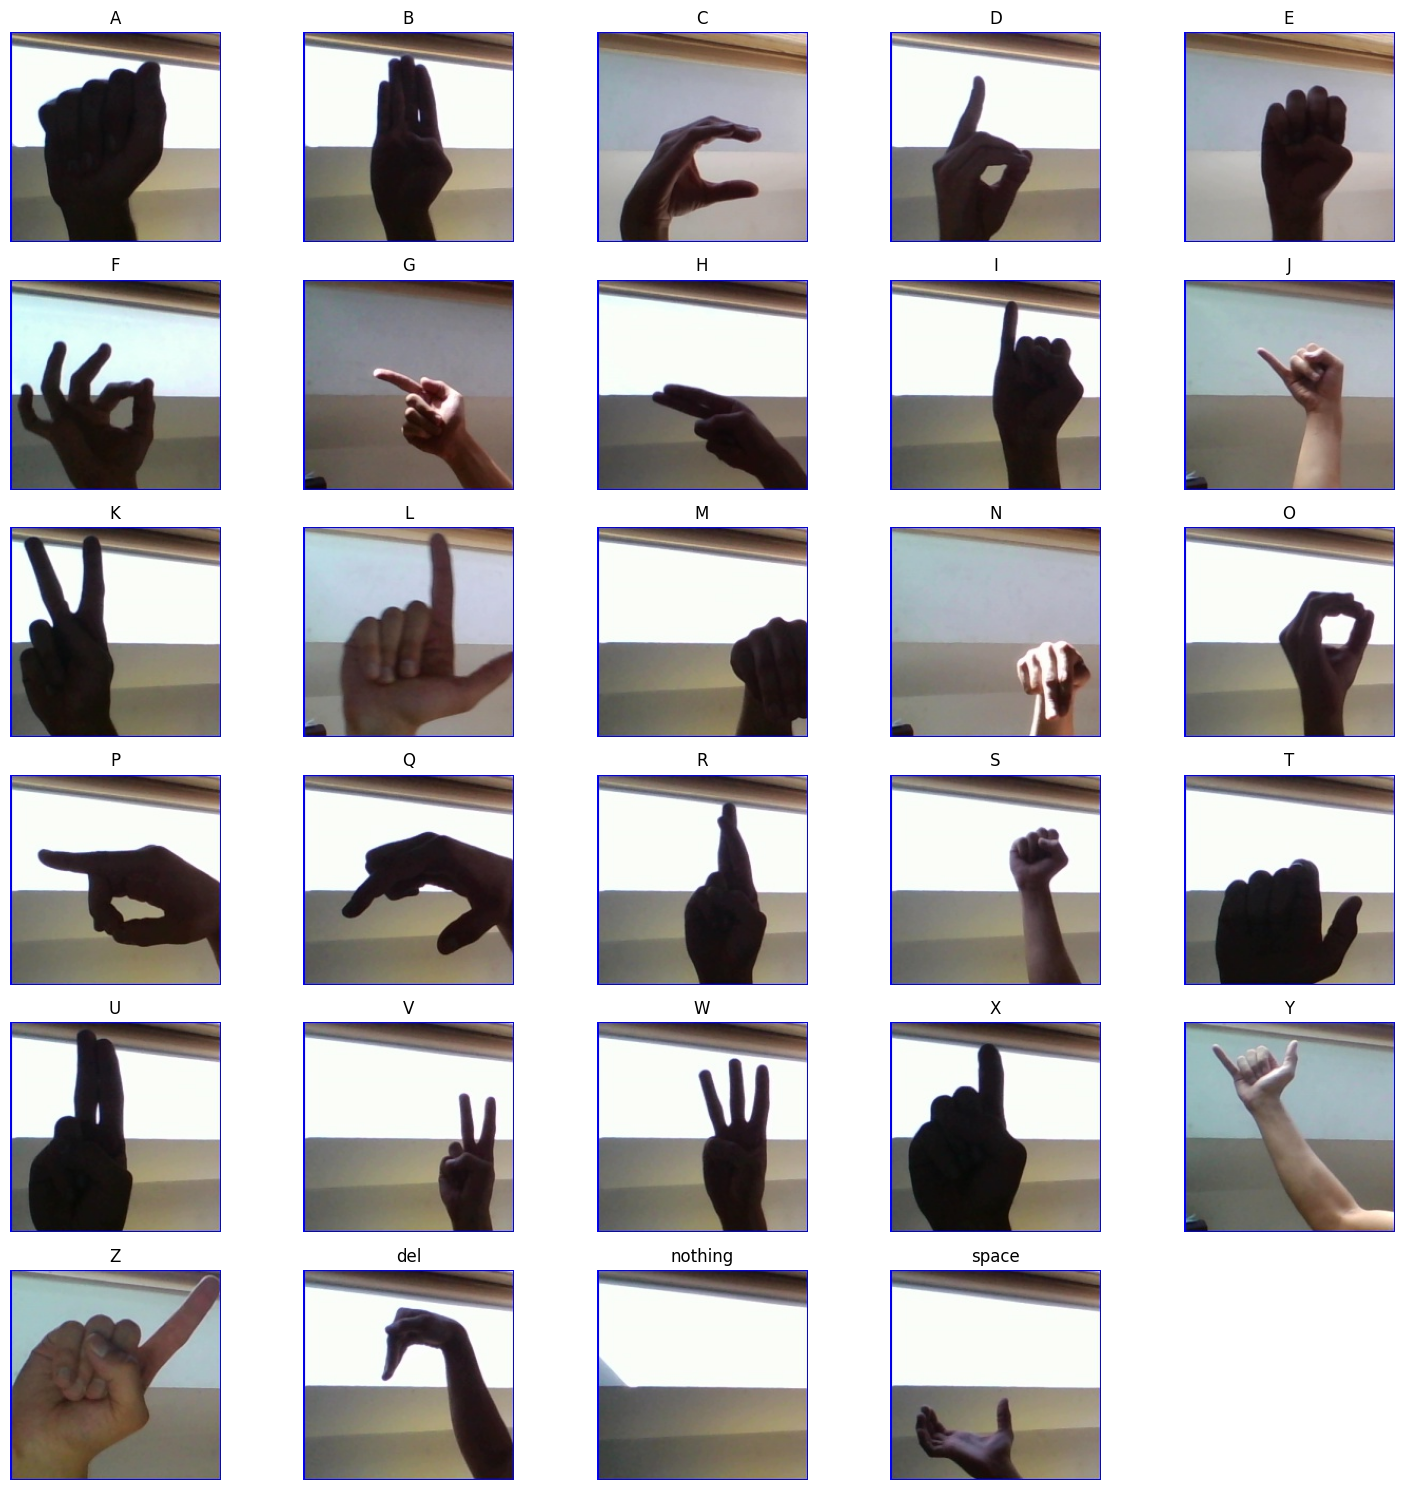

In [11]:
plt.figure(figsize=(15, 15))
rows = int(np.ceil(len(dls.vocab) / 5))

for i, cls in enumerate(dls.vocab):
    sample_path = list(path.glob(f"{cls}/*"))[0]
    img = PILImage.create(sample_path)
    plt.subplot(rows, 5, i+1)
    plt.imshow(img)
    plt.title(f"{cls}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### A.3.3 Summarize the DataBlock: dataloader.summary(path/data)

In this part, I tried to understand these steps with the summary() method, which allows me to see : <br>
How the dataset is split into test and train,<br>
How the images change individually,<br>
How the batches change,<br>
How the images within the batches change.

In [12]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 87000 items
2 datasets of sizes 69600,17400
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/datasets/asl_alphabet/I/I2927.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=200x200
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/datasets/asl_alphabet/I/I2927.jpg
    applying parent_label gives
      I
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=200x200, TensorCategory(8))


Found 87000 items
2 datasets of sizes 69600,17400
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up a

## A.4. Train a simple model

### A.4.1 Create a benchmark

Here I created a simple model to see the effect of further steps with a simpler architecture like Resnet 18.

In [13]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate], path="benchmark")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


In [14]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.010560,0.342319,0.892529,0.107471,03:11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.312260,0.018803,0.995977,0.004023,02:47


### A.4.2 Interpret the model

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

### A.4.3 Confusion matrix

Here, I examined the output of the sample's true class and predicted labels using "Confusion Matrix".

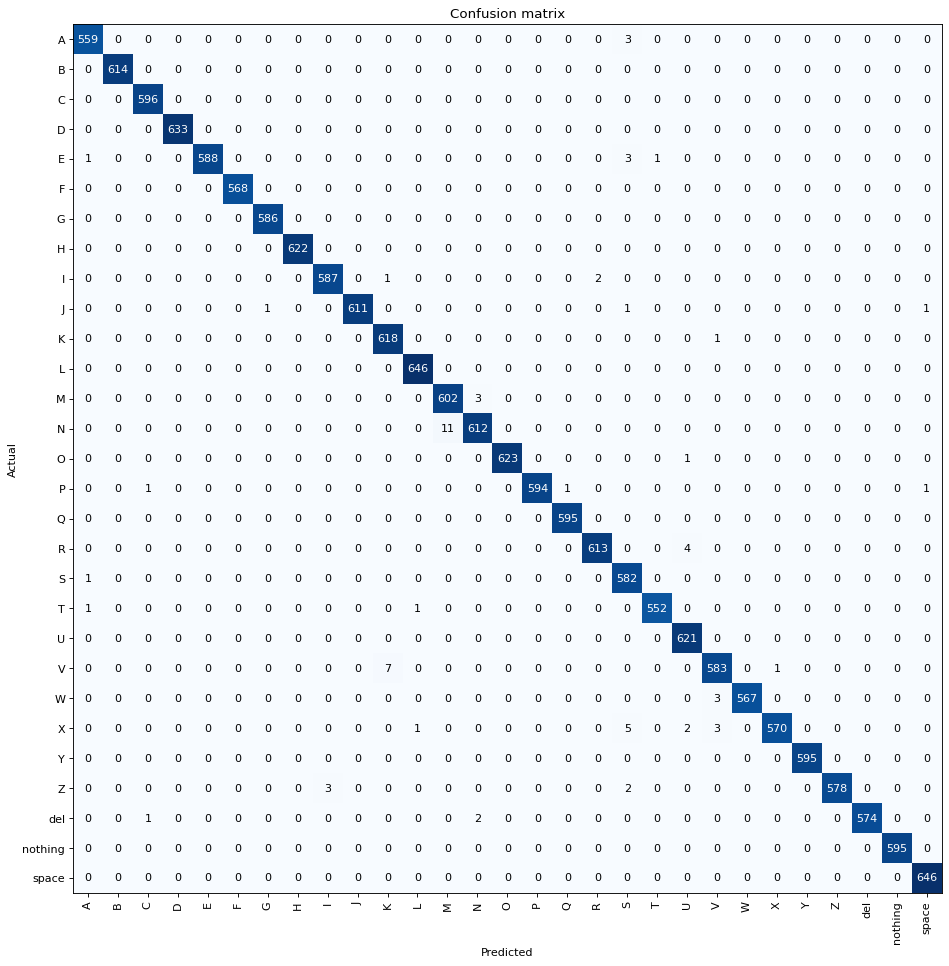

In [16]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=80)

Here I checked the predictions that were confused with the lowest correct prediction. I did not expect some results.</br>
For example, s and z are not really similar to each other. I thought it was more likely to confuse s with a, but it did not happen here.</br>
I can say that it was normal to confuse m and n.

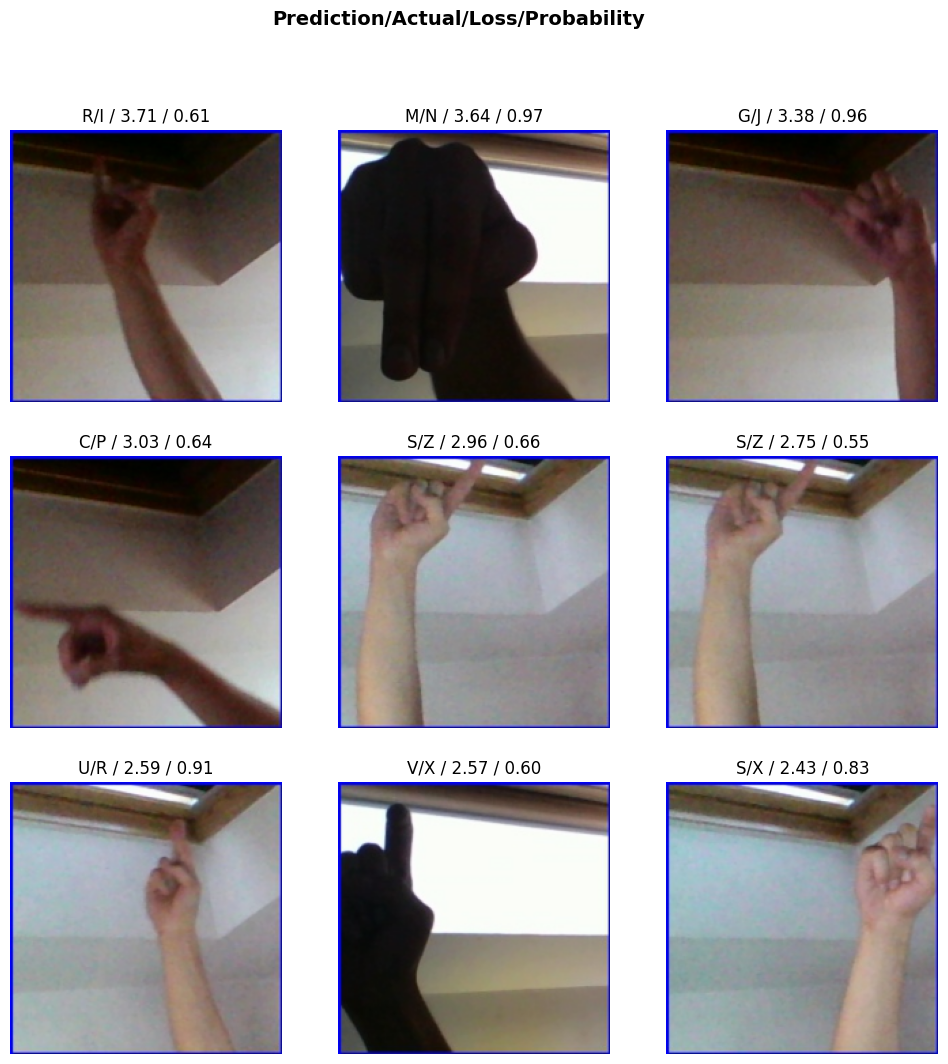

In [17]:
interp.plot_top_losses(9, figsize=(12, 12))

## B.1. Learning Rate Finder && B.2. Finder Algorithm:

The lr_find() method I used here uses a learning rate that is larger than the previous one in each batch, as you wish. Then creates this graph by taking the loss value in each step. The green dot in this graph represents lr_steep, the learning rate value with the highest loss decrease compared to the previous step, and the orange dot represents lr_min, the learning rate with the lowest loss value.

In [18]:
learn2 = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], path="lr_finder_model")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]


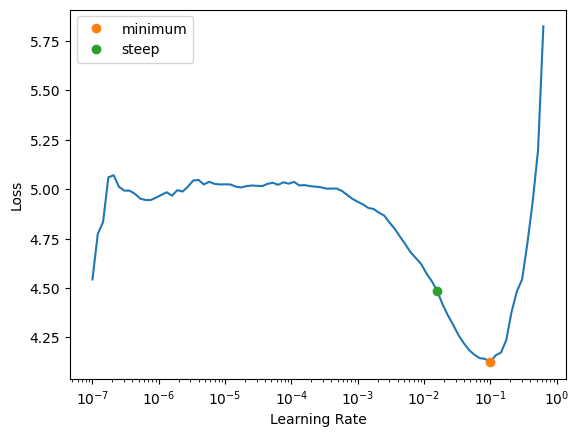

In [19]:
lr_min, lr_steep = learn2.lr_find(suggest_funcs=(minimum,steep))

print(f"Minimum/10: {lr_min:.3e}, steepest point: {lr_steep:.3e}")
#0.01202 and 0.00631

The 4e-3 value I used as base_lr here is a value I preferred, considering the graphics and information in the book.

In [21]:
learn2.fine_tune(2, base_lr=4e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.805478,0.198387,0.932126,0.067874,02:49


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.334066,0.042537,0.985460,0.014540,02:50
1,0.159499,0.001888,0.999540,0.000460,02:50


## B.3 Transfer Learning

The learning rate used in training the first layers should not be the same as the learning rate in the last layer which is the fine-tuning layer. Since the first layers have already been trained with very large data for certain tasks,  it does not need much change. However, when the last layer is the layer that needs to be adjusted to fit the model to our data, it can be trained with a larger learning rate than the first layers, changing more.

### B.3.1 Old final linear layer F of size mxn (n is the number of classes)
### B.3.2 Replace the trained F with a new one F' of size mxk (k is the number of classes in the new

Here, by giving my own data, I have converted the last layer of the resnet34 model that I used from n to k. Here, k is equal to my label count of 29.

In [22]:
learn3 = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], path="transfer_learning_model")

### B.3.3 Only train F' while using the previous weights unchanged (called Freezing)

In [23]:
learn3.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.411734,0.036265,0.989540,0.010460,02:48


### B.3.4 Continue training all the weights F' and previous weights (called Unfreezing)

In [24]:
learn3.unfreeze()

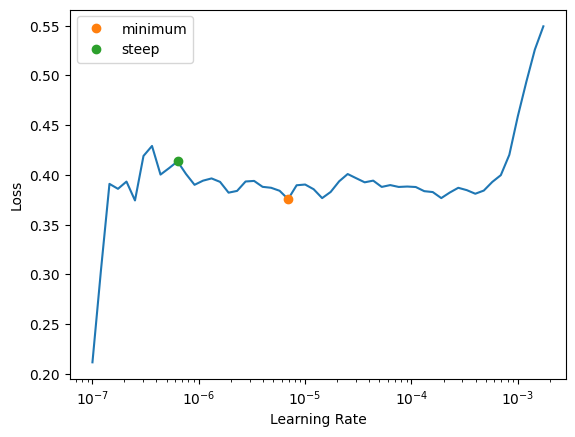

In [25]:
lr_min, lr_steep = learn3.lr_find(suggest_funcs=(minimum,steep))

In [26]:
print(f"Minimum/10: {lr_min:.3e}, steepest point: {lr_steep:.3e}")

Minimum/10: 6.918e-07, steepest point: 6.310e-07


In [27]:
learn3.fit_one_cycle(2, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.323371,0.020086,0.994080,0.005920,02:50
1,0.284562,0.014241,0.996667,0.003333,02:50


## B.4. Discriminative Learning Rates

Discriminative Learning Rates allows us to further develop the use of different learning rates for the first and last layers in the previous step. So, it allows the first and last layers to be trained with different learning rate values after the model is unfreezed.

In [28]:
learn4 = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], path="discriminative_learning_model")

In [29]:
learn4.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.425379,0.043588,0.987471,0.012529,02:49


In [30]:
learn4.unfreeze()

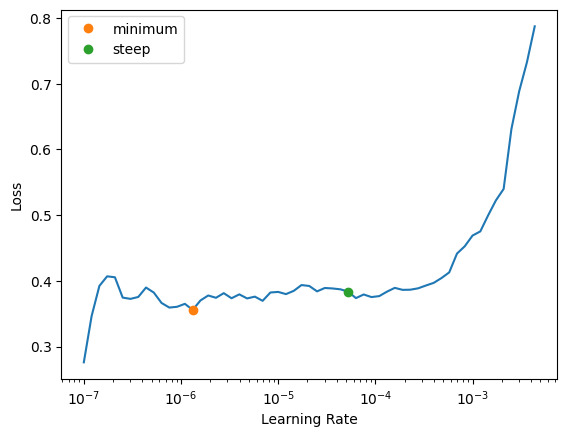

In [31]:
lr_min, lr_steep = learn4.lr_find(suggest_funcs=(minimum,steep))

In [32]:
learn4.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.320965,0.021323,0.994943,0.005057,02:50
1,0.290203,0.014905,0.996609,0.003391,02:49


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

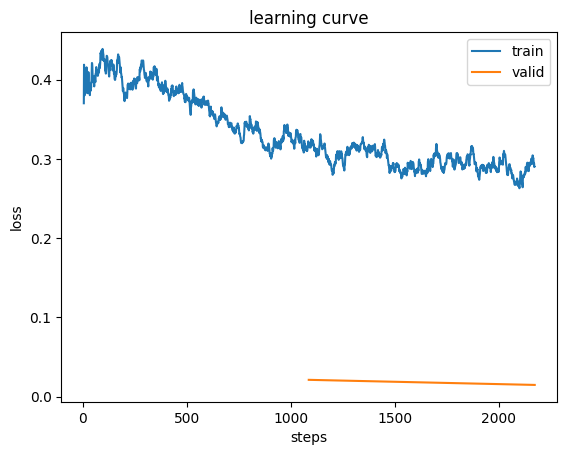

In [33]:
learn4.recorder.plot_loss()

## B.5. Deciding the Number of Training Epochs

We can train the model as much as we want, the model’s accuracy value may continue to increase, but this does not mean that the model generalizes well, that is, it will work with high accuracy on other data.

Early stopping can stop training after catching this step, but it can also make a wrong assumption and cause the model not to be trained better. Therefore, as a good method, it makes sense to train the model at a high epcoh number and examine the val_loss, train_loss graph.

In [34]:
learn5 = vision_learner(dls, resnet18, metrics=[accuracy, error_rate], path="decide_epoch_model")

In [35]:
learn5.fit_one_cycle(50, 4e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.086627,0.272088,0.923563,0.076437,02:47
1,0.666538,0.122010,0.966954,0.033046,02:47
2,0.522440,0.064331,0.981667,0.018333,02:48
3,0.432574,0.055143,0.982759,0.017241,02:48
4,0.438018,0.049899,0.985287,0.014713,02:48
5,0.437922,0.034920,0.990115,0.009885,02:47
6,0.415457,0.036924,0.987759,0.012241,02:48
7,0.409478,0.044366,0.986207,0.013793,02:47
8,0.411013,0.046671,0.985862,0.014138,02:48
9,0.414261,0.043854,0.986609,0.013391,02:48


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

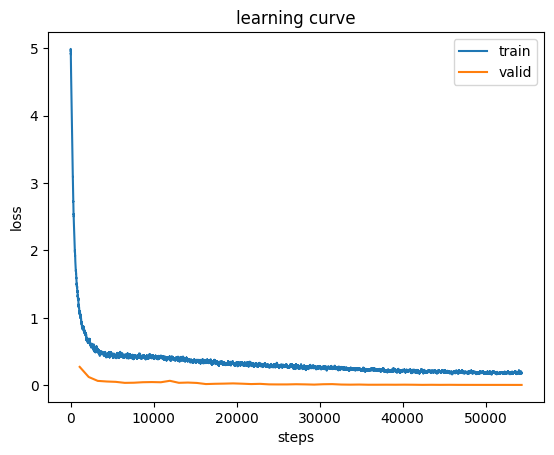

In [36]:
learn5.recorder.plot_loss()

## B.6. Model Capacity


Depending on our data and hardware, we can train models with different complexities. I wanted to try this project using different complexity architectures with different batch numbers.

In [56]:
dls16 = dblock.dataloaders(path, bs=16)
learn_resnet101  = vision_learner(dls16, resnet101, metrics=[accuracy, error_rate], path="resnet101")

learn_resnet101.to_fp16()
learn_resnet101.fit_one_cycle(3, 4e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.446207,0.027136,0.990920,0.009080,09:08
1,0.321450,0.006482,0.998448,0.001552,08:49
2,0.247854,0.003730,0.999023,0.000977,08:52


In [58]:
dls32 = dblock.dataloaders(path, bs=32)
learn_resnet50  = vision_learner(dls32, resnet50, metrics=[accuracy, error_rate], path="resnet50")

learn_resnet50.to_fp16()
learn_resnet50.fit_one_cycle(3, 4e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.543362,0.029592,0.990805,0.009195,04:16
1,0.276771,0.007558,0.998046,0.001954,04:01
2,0.211614,0.003661,0.999138,0.000862,04:00


In [60]:
dls64 = dblock.dataloaders(path, bs=64)
learn_resnet34  = vision_learner(dls64, resnet34, metrics=[accuracy, error_rate], path="resnet34")

learn_resnet34.to_fp16()
learn_resnet34.fit_one_cycle(3, 4e-3)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.263599,0.318736,0.925862,0.074138,03:12
1,0.867338,0.134971,0.962586,0.037414,02:49
2,0.714233,0.093248,0.976437,0.023563,02:49


In [65]:
all_losses = {}
all_losses['ResNet101 (bs=16, fp16)'] = learn_resnet101.recorder.losses
all_losses['ResNet50 (bs=32, fp16)'] = learn_resnet50.recorder.losses
all_losses['ResNet34 (bs=64, fp16)'] = learn_resnet34.recorder.losses

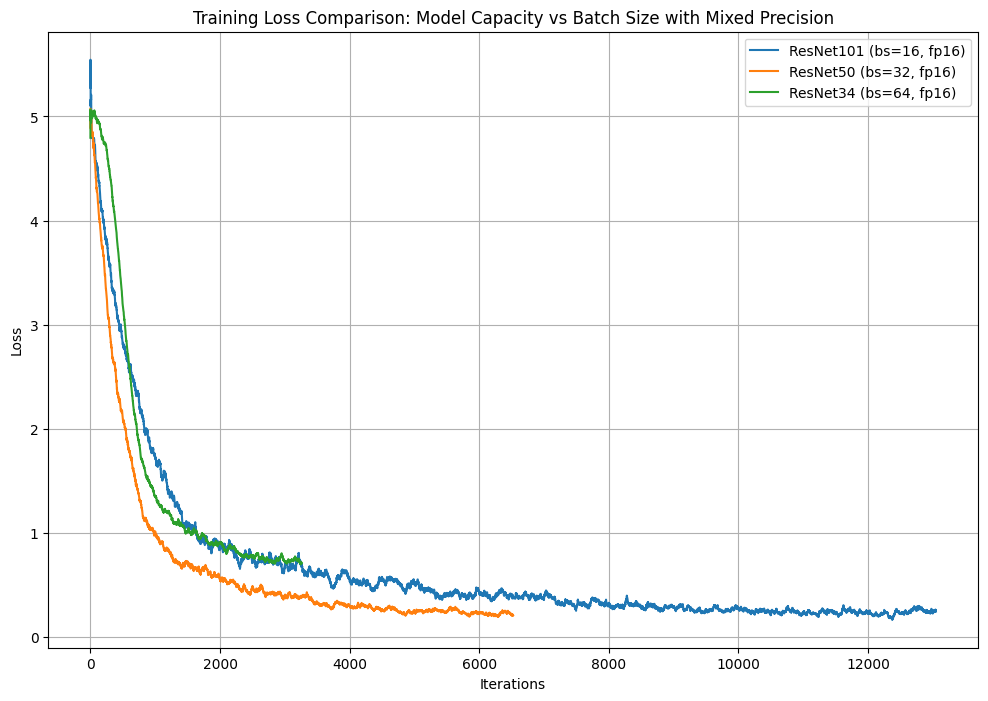

In [63]:
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)
plt.title('Training Loss Comparison: Model Capacity vs Batch Size with Mixed Precision')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

This graph shows that the most accurate is not always the most complex model, and that different architectures and parameters should be preferred for different data types.